# Complete Exploratory Data Analysis

In [135]:
from pathlib import Path
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import binomtest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns

sns.set_theme(style="whitegrid")

CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent]
PROJECT_ROOT = next(
    (p for p in CANDIDATE_ROOTS if (p / "data").exists() and (p / "template").exists()),
    None,
)
if PROJECT_ROOT is None:
    raise FileNotFoundError("Could not find project root with /data and /template directories. Ensure that you are running this notebook from within the project directory.")

DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = PROJECT_ROOT / "eda" / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

COIN_METRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"COINMETRICS_PATH exists: {COIN_METRICS_PATH.exists()}")
print(f"POLYMARKET_DIR exists: {POLYMARKET_DIR.exists()}")

PROJECT_ROOT: /Users/maxmidlash/bitcoin-analytics-capstone-template
COINMETRICS_PATH exists: True
POLYMARKET_DIR exists: True


## 1) Load CoinMetrics BTC Data

In [136]:
def load_bitcoin_data(filepath: Path) -> pl.DataFrame:
    df = (
        pl.scan_csv(filepath, infer_schema_length=10000)
        .with_columns(pl.col("time").str.to_datetime())
        .collect()
        .sort("time")
    )

    if "PriceUSD" in df.columns and "PriceUSD_coinmetrics" not in df.columns:
        df = df.with_columns(pl.col("PriceUSD").alias("PriceUSD_coinmetrics"))

    return df

btc_df = load_bitcoin_data(COIN_METRICS_PATH)
print(f"Loaded BTC rows: {btc_df.height:,} | columns: {btc_df.width}")
btc_df.head(3)

Loaded BTC rows: 6,221 | columns: 33


time,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,HashRate,IssTotNtv,IssTotUSD,PriceBTC,PriceUSD,ROI1yr,ROI30d,ReferenceRate,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d,PriceUSD_coinmetrics
datetime[μs],i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64
2009-01-03 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null,null
2009-01-04 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null,null
2009-01-05 00:00:00,0,0,1614334883,1614334883,0,null,null,null,0.0,0.0,null,0.0,null,null,null,null,1,null,null,null,null,null,null,null,0.0,0.0,null,null,0,0,null,null


## 2) Load Polymarket Data

In [137]:
def _fix_timestamp_columns(df: pl.DataFrame) -> pl.DataFrame:
    """Fix parquet timestamps and null out pre-2020 values"""
    threshold_dt = datetime(2020, 1, 1)

    for col in df.columns:
        if not any(k in col.lower() for k in ["timestamp", "trade", "created_at", "end_date"]):
            continue
    
        dtype = df.schema[col]
        if not dtype.is_temporal():
            continue

        if dtype == pl.Datetime:
            max_val = df.select(pl.col(col).max()).item()
            if max_val is not None and max_val < threshold_dt:
                df = df.with_columns((pl.col(col).cast(pl.Int64) * 1000).cast(pl.Datetime).alias(col))

        threshold_value = threshold_dt.date() if dtype == pl.Date else threshold_dt
        df = df.with_columns(
            pl.when(pl.col(col) < threshold_value)
            .then(None)
            .otherwise(pl.col(col))
            .alias(col)
        )
    
    return df

def load_polymarket_data(datadir: Path) -> dict[str, pl.DataFrame]:
    data: dict[str, pl.DataFrame] = {}
    for path in datadir.glob("*.parquet"):
        key = path.stem.replace("finance_politics_", "")

        df = pl.scan_parquet(path).collect()
        df = _fix_timestamp_columns(df)
        data[key] = df
        print(f"Loaded {key}: {df.height:,} rows x {df.width} columns")
    
    return data

poly_data = load_polymarket_data(POLYMARKET_DIR)
list(poly_data.keys())

Loaded odds_history: 2,143,181 rows x 4 columns
Loaded summary: 78,321 rows x 9 columns
Loaded trades: 27,013,724 rows x 9 columns
Loaded markets: 78,321 rows x 10 columns
Loaded tokens: 156,636 rows x 3 columns
Loaded event_stats: 44,033 rows x 5 columns


['odds_history', 'summary', 'trades', 'markets', 'tokens', 'event_stats']

## 3) Basic BTC EDA

In [138]:
print(f"BTC date range: {btc_df.select(pl.col('time').min()).item()} -> {btc_df.select(pl.col('time').max()).item()}")
print(f"BTC shape: {btc_df.shape}")

key_btc_cols = [c for c in ["PriceUSD_coinmetrics", "CapMrktCurUSD", "HashRate", "TxCnt", "CapMVRVCur"] if c in btc_df.columns]

btc_missing = pl.DataFrame(
    {
        "column": key_btc_cols,
        "null_pct": [100 * btc_df[c].null_count() / btc_df.height for c in key_btc_cols],
    }
).sort("null_pct", descending=True)

btc_summary = btc_df.select(key_btc_cols).describe()

btc_missing, btc_summary


BTC date range: 2009-01-03 00:00:00 -> 2026-01-14 00:00:00
BTC shape: (6221, 33)


(shape: (5, 2)
 ┌──────────────────────┬──────────┐
 │ column               ┆ null_pct │
 │ ---                  ┆ ---      │
 │ str                  ┆ f64      │
 ╞══════════════════════╪══════════╡
 │ PriceUSD_coinmetrics ┆ 9.033917 │
 │ CapMrktCurUSD        ┆ 9.033917 │
 │ CapMVRVCur           ┆ 9.033917 │
 │ HashRate             ┆ 0.112522 │
 │ TxCnt                ┆ 0.016075 │
 └──────────────────────┴──────────┘,
 shape: (9, 6)
 ┌────────────┬──────────────────────┬───────────────┬───────────┬───────────────┬────────────┐
 │ statistic  ┆ PriceUSD_coinmetrics ┆ CapMrktCurUSD ┆ HashRate  ┆ TxCnt         ┆ CapMVRVCur │
 │ ---        ┆ ---                  ┆ ---           ┆ ---       ┆ ---           ┆ ---        │
 │ str        ┆ f64                  ┆ f64           ┆ f64       ┆ f64           ┆ f64        │
 ╞════════════╪══════════════════════╪═══════════════╪═══════════╪═══════════════╪════════════╡
 │ count      ┆ 5659.0               ┆ 5659.0        ┆ 6214.0    ┆ 6220.0        ┆

In [139]:
print("Missing Data: ")
with pl.Config(tbl_rows=20):
    display(
        btc_df.filter(pl.col("time") < btc_df["time"].max())
        .unpivot(index="time")
        .filter(pl.col("value").is_null())
        .group_by("variable")
        .agg(
            pl.col("time").min().alias("missing_start"),
            pl.col("time").max().alias("missing_end"),
            pl.col("time").count().alias("missing_count")
        )
        .sort("missing_count", descending=True)
    )

Missing Data: 


variable,missing_start,missing_end,missing_count
str,datetime[μs],datetime[μs],u32
"""ReferenceRateUSD""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRate""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRateETH""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""ReferenceRateEUR""",2009-01-03 00:00:00,2026-01-07 00:00:00,6214
"""CapMrktEstUSD""",2009-01-03 00:00:00,2019-06-21 00:00:00,3822
"""ROI1yr""",2009-01-03 00:00:00,2011-07-17 00:00:00,926
"""ROI30d""",2009-01-03 00:00:00,2010-08-16 00:00:00,591
"""PriceUSD""",2009-01-03 00:00:00,2010-07-17 00:00:00,561
"""CapMVRVCur""",2009-01-03 00:00:00,2010-07-17 00:00:00,561


##  3 a) Examine Correlations

Original numeric columns: 31
Columns selected for correlation: 25


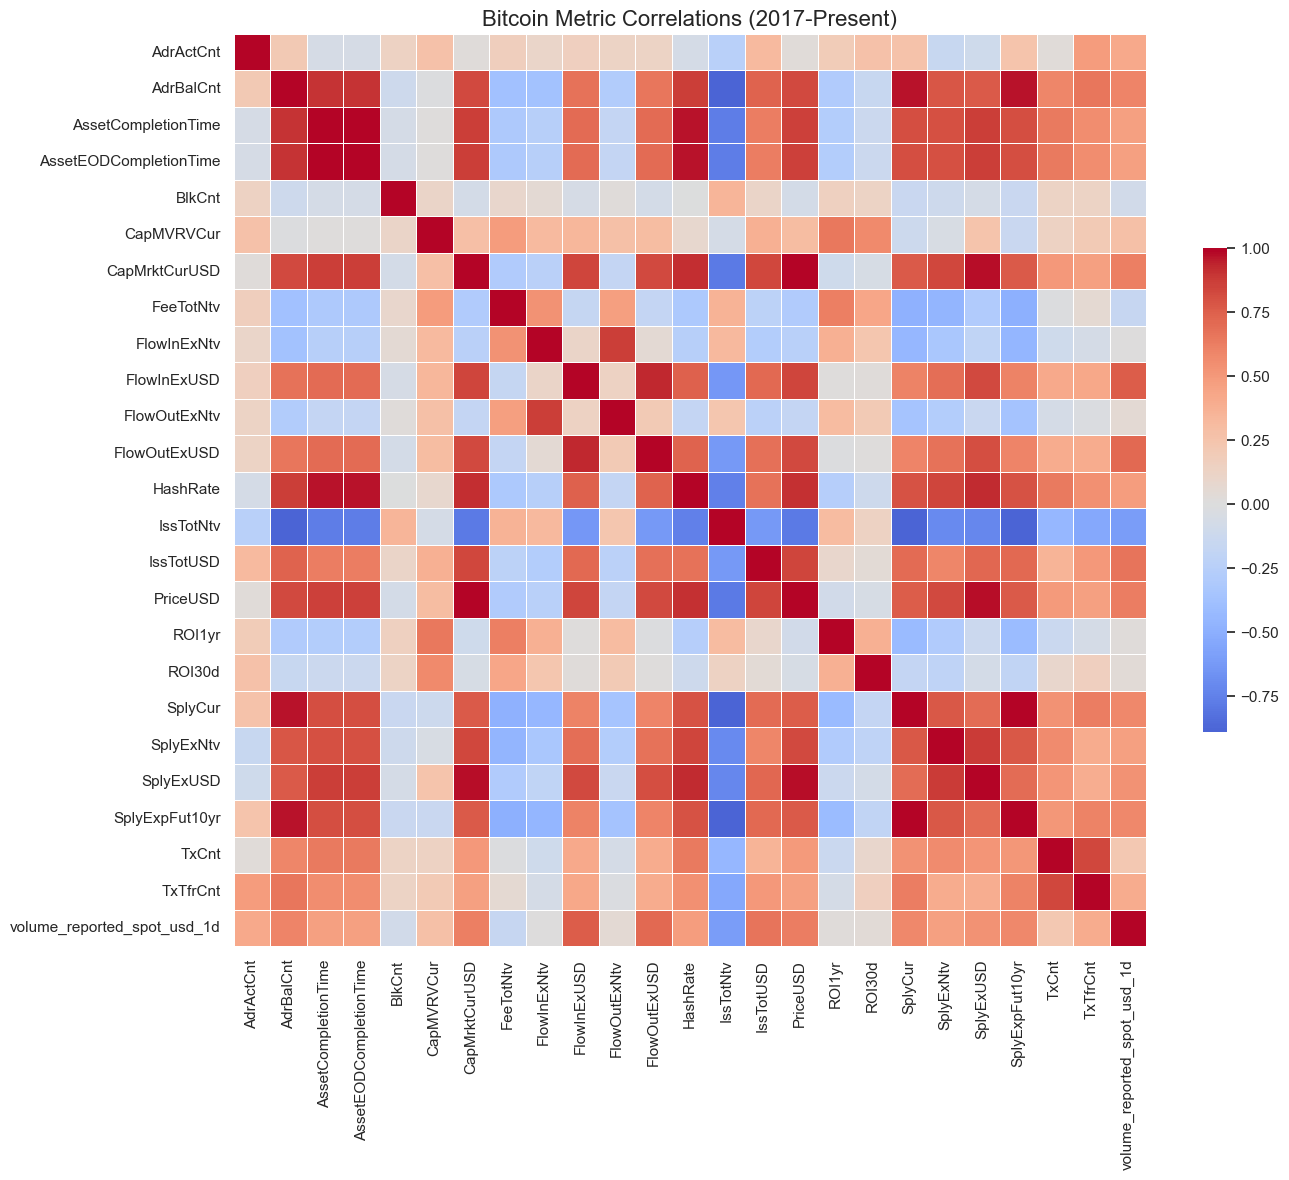

In [140]:
# Filter for data starting from 2017
df_eda = btc_df.filter(pl.col("time").dt.year() >= 2017)

numeric_df = df_eda.select(cs.numeric() - cs.by_name("PriceUSD_coinmetrics"))

valid_cols = []
for col in numeric_df.columns:
    series = numeric_df[col]
    
    if (series.null_count() / len(series)) > 0.2:
        continue
        
    if series.drop_nulls().n_unique() <= 1:
        continue
        
    valid_cols.append(col)

print(f"Original numeric columns: {len(numeric_df.columns)}")
print(f"Columns selected for correlation: {len(valid_cols)}")

corr_df = df_eda.select(valid_cols).drop_nulls().to_pandas().corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_df, 
    annot=False,
    cmap="coolwarm", 
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5}
)

plt.title("Bitcoin Metric Correlations (2017-Present)", fontsize=16)
plt.tight_layout()
plt.show()

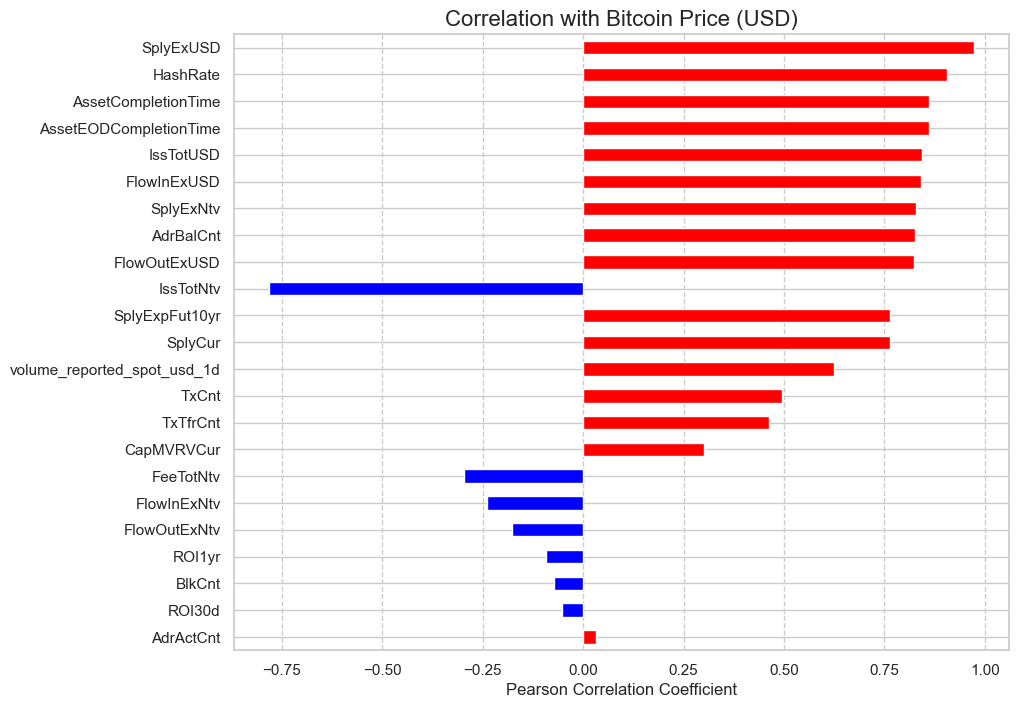

In [141]:
# Correlation series for just PriceUSD
target_corr = corr_df["PriceUSD"].drop(["PriceUSD", "CapMrktCurUSD"])

sorted_corr = target_corr.iloc[target_corr.abs().argsort()]

plt.figure(figsize=(10, 8))
colors = ['red' if x > 0 else 'blue' for x in sorted_corr.values]
sorted_corr.plot(kind='barh', color=colors)

plt.title("Correlation with Bitcoin Price (USD)", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient")
plt.grid(axis='x', linestyle='--')
plt.show()

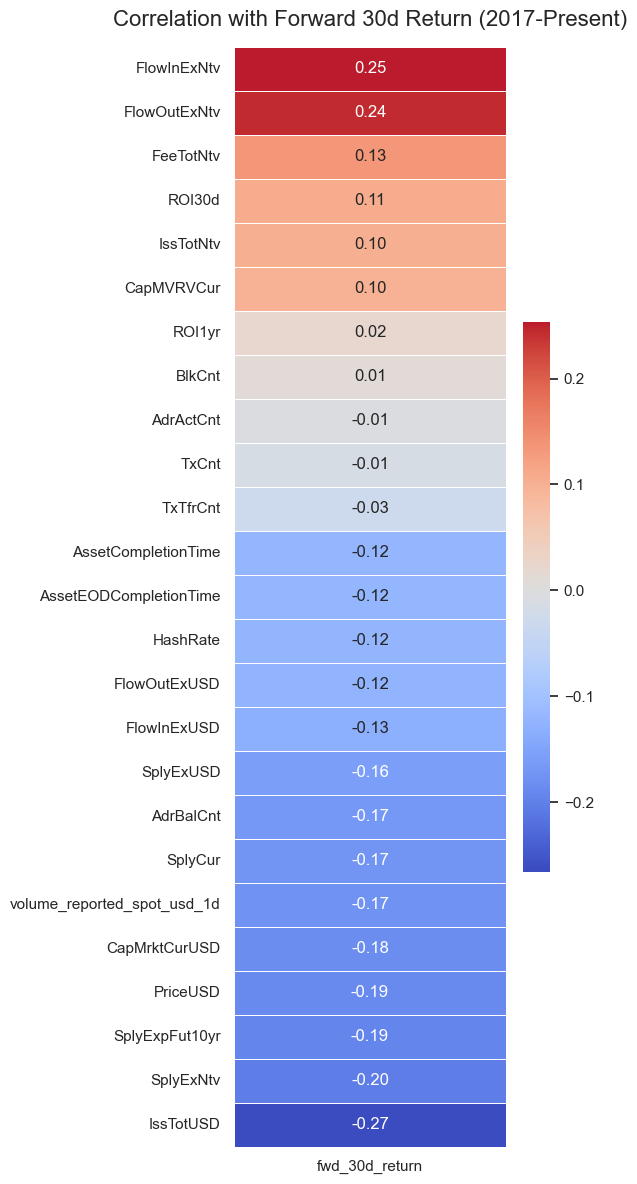

In [170]:
# Correlations with forward 30-day returns

df_returns = btc_df.with_columns(
    ((pl.col("PriceUSD_coinmetrics").shift(-30) / pl.col("PriceUSD_coinmetrics")) - 1).alias("fwd_30d_return")
)

df_returns_eda = df_returns.filter(pl.col("time").dt.year() >= 2017)

cols_to_keep = valid_cols + ["fwd_30d_return"]

corr_with_fwd = (
    df_returns_eda.select(cols_to_keep)
    .drop_nulls()
    .to_pandas()
    .corr()[["fwd_30d_return"]]
    .drop("fwd_30d_return")
    .sort_values(by="fwd_30d_return", ascending=False)
)

plt.figure(figsize=(6, 12))

sns.heatmap(
    corr_with_fwd, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm", 
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5}
)

plt.title("Correlation with Forward 30d Return (2017-Present)", fontsize=16, pad=15)
plt.ylabel("")
plt.tight_layout()
plt.show()

##  3 b) Complete BTC Price Plot

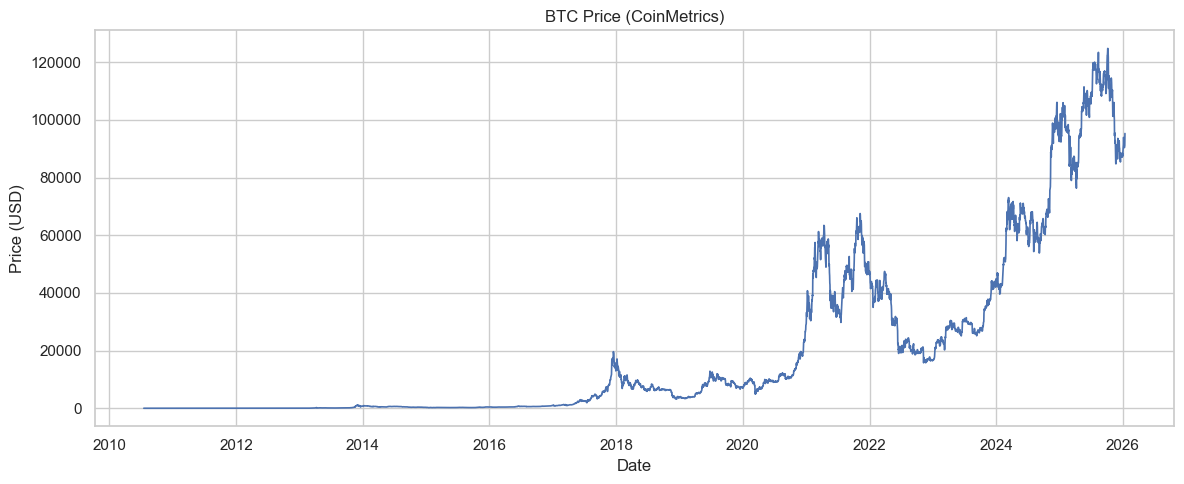

In [142]:
btc_price_pd = (
    btc_df
    .select(["time", "PriceUSD_coinmetrics"])
    .drop_nulls()
    .to_pandas()
)

plt.figure(figsize=(12, 5))
plt.plot(btc_price_pd["time"], btc_price_pd["PriceUSD_coinmetrics"], linewidth=1.2)
plt.title("BTC Price (CoinMetrics)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

## 3 c) BTC Price vs HashRate Plot (Post 2017)

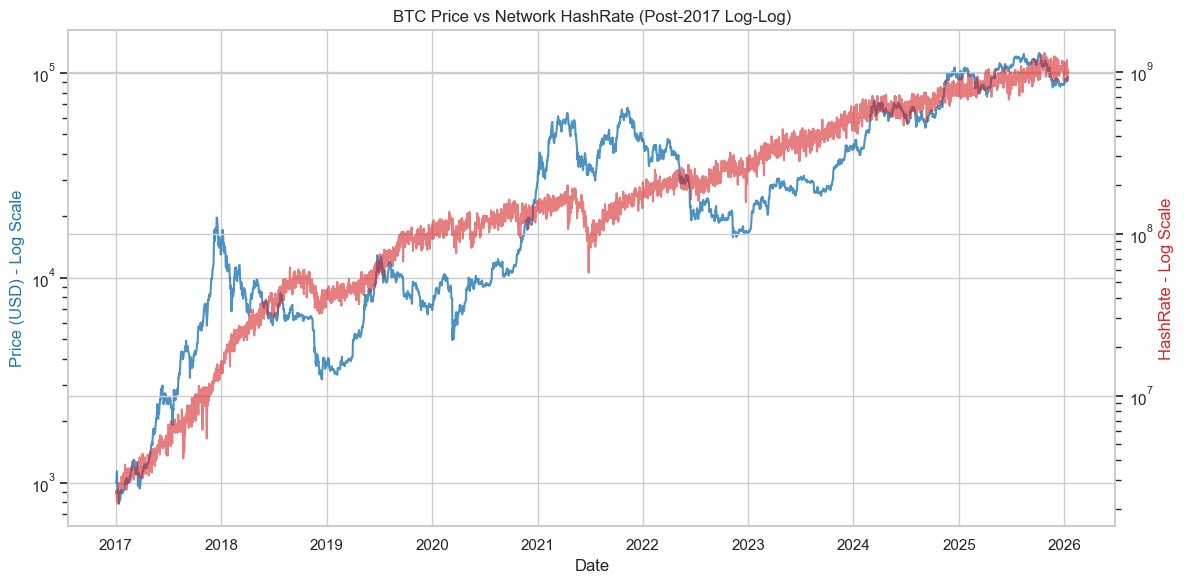

In [143]:
onchain_df = btc_df.select(["time", "PriceUSD_coinmetrics", "HashRate", "CapMVRVCur"]).drop_nulls().to_pandas()
onchain_df["time"] = pd.to_datetime(onchain_df["time"])

# Filter to post-2017
onchain_df = onchain_df[onchain_df["time"] >= "2017-01-01"]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(onchain_df["time"], onchain_df["PriceUSD_coinmetrics"], color="tab:blue", label="BTC Price", alpha=0.8)
ax1.set_yscale("log")
ax1.set_ylabel("Price (USD) - Log Scale", color="tab:blue")
ax1.set_xlabel("Date")

ax2 = ax1.twinx()
ax2.plot(onchain_df["time"], onchain_df["HashRate"], color="tab:red", label="HashRate", alpha=0.6)
ax2.set_yscale("log")
ax2.set_ylabel("HashRate - Log Scale", color="tab:red")

plt.title("BTC Price vs Network HashRate (Post-2017 Log-Log)")
fig.tight_layout()
plt.show()

## 3 d) BTC MVRV Plots (Post 2017)

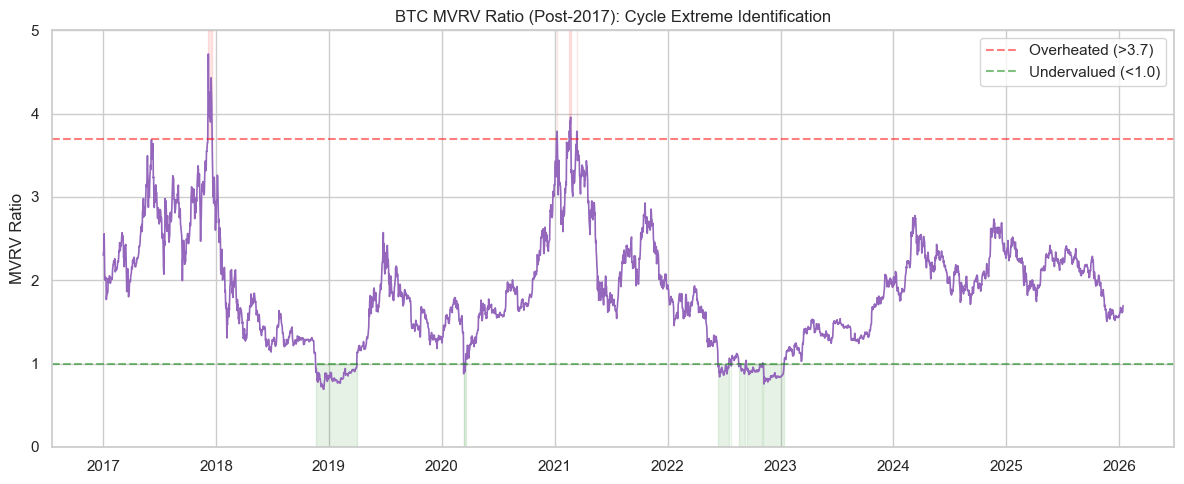

In [144]:
plt.figure(figsize=(12, 5))
plt.plot(onchain_df["time"], onchain_df["CapMVRVCur"], color="tab:purple", linewidth=1.2)

plt.axhline(3.7, color="red", linestyle="--", alpha=0.5, label="Overheated (>3.7)")
plt.axhline(1.0, color="green", linestyle="--", alpha=0.5, label="Undervalued (<1.0)")

plt.fill_between(onchain_df["time"], 0, 1, where=(onchain_df["CapMVRVCur"] < 1), color="green", alpha=0.1)
plt.fill_between(onchain_df["time"], 3.7, 5, where=(onchain_df["CapMVRVCur"] > 3.7), color="red", alpha=0.1)

plt.ylim(0, 5)
plt.title("BTC MVRV Ratio (Post-2017): Cycle Extreme Identification")
plt.ylabel("MVRV Ratio")
plt.legend()
plt.tight_layout()
plt.show()

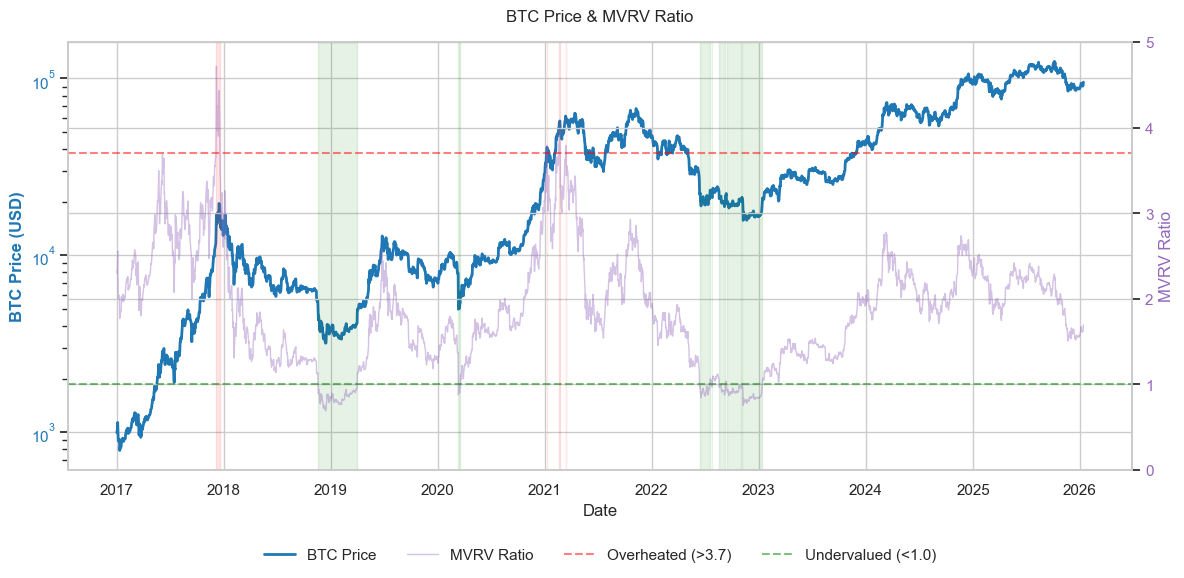

In [145]:
start_date = onchain_df["time"].min()
plot_price_pd = btc_price_pd[btc_price_pd["time"] >= start_date]

fig, ax1 = plt.subplots(figsize=(12, 6))

color_price = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color=color_price, fontweight="bold")

ax1.plot(plot_price_pd["time"], plot_price_pd["PriceUSD_coinmetrics"], color=color_price, linewidth=2.0, label="BTC Price")
ax1.tick_params(axis="y", labelcolor=color_price)
ax1.set_yscale("log")

ax2 = ax1.twinx()
color_mvrv = "tab:purple"
ax2.set_ylabel("MVRV Ratio", color=color_mvrv)

ax2.plot(onchain_df["time"], onchain_df["CapMVRVCur"], color=color_mvrv, linewidth=1.0, alpha=0.4, label="MVRV Ratio")

ax2.axhline(3.7, color="red", linestyle="--", alpha=0.5, label="Overheated (>3.7)")
ax2.axhline(1.0, color="green", linestyle="--", alpha=0.5, label="Undervalued (<1.0)")

ax2.fill_between(onchain_df["time"], 0, 5, where=(onchain_df["CapMVRVCur"] > 3.7), color="red", alpha=0.1)
ax2.fill_between(onchain_df["time"], 0, 5, where=(onchain_df["CapMVRVCur"] < 1), color="green", alpha=0.1)

ax2.set_ylim(0,5)
ax2.tick_params(axis="y", labelcolor=color_mvrv)

plt.title("BTC Price & MVRV Ratio", pad=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

fig.tight_layout()
plt.show()

## 3 e) Network Adoption: Active Address Growth vs Returns

We explore the hypothesis that network growth (adoption) leads price discovery. We calculate the 30-day percentage change in Active Addresses and compare it to the forward 30-day BTC returns.

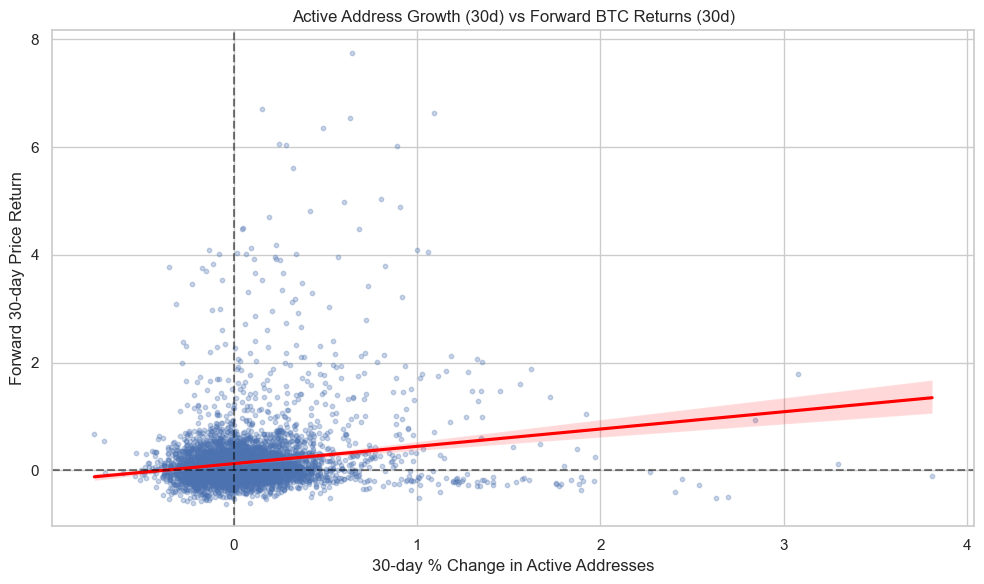

Correlation between 30d Address Growth and Forward 30d Returns: 0.1703


In [146]:
adoption_df = btc_df.select(["time", "PriceUSD_coinmetrics", "AdrActCnt"]).drop_nulls().to_pandas()
adoption_df["time"] = pd.to_datetime(adoption_df["time"])

# 30 day Adoption Growth (Lagged)
adoption_df["addr_growth_30d"] = adoption_df["AdrActCnt"].pct_change(30)

# 30 day Price Return (Forward)
adoption_df["fwd_ret_30d"] = adoption_df["PriceUSD_coinmetrics"].shift(-30) / adoption_df["PriceUSD_coinmetrics"] - 1

plot_df = adoption_df.dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=plot_df, x="addr_growth_30d", y="fwd_ret_30d",
            scatter_kws={'alpha':0.3, "s":10}, line_kws={'color':'red'})

plt.title("Active Address Growth (30d) vs Forward BTC Returns (30d)")
plt.xlabel("30-day % Change in Active Addresses")
plt.ylabel("Forward 30-day Price Return")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

correlation = plot_df["addr_growth_30d"].corr(plot_df["fwd_ret_30d"])
print(f"Correlation between 30d Address Growth and Forward 30d Returns: {correlation:.4f}")

## 3 f) Exchange Flows vs Returns

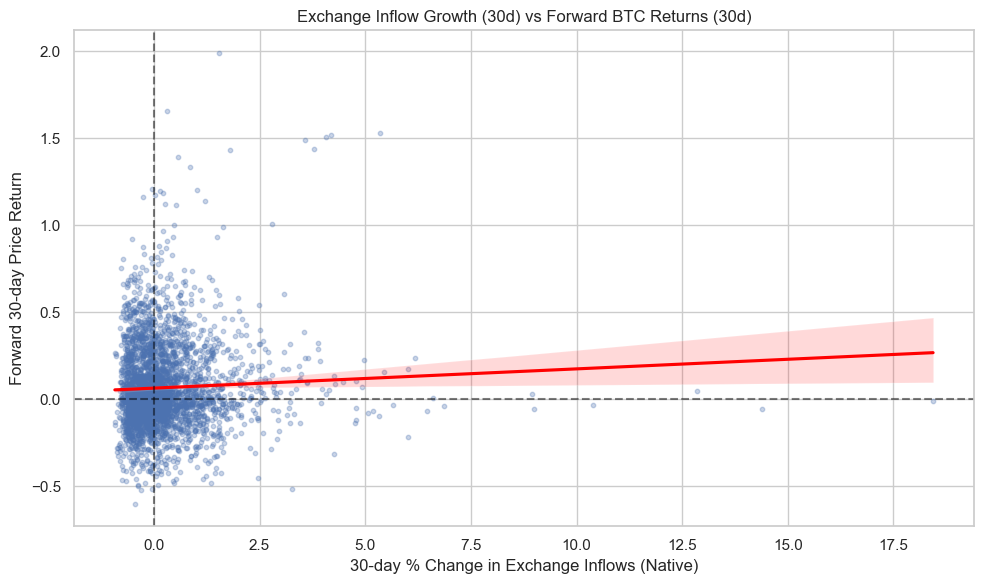

Correlation between 30d Inflow Growth and Forward 30d Returns: 0.0468


In [172]:
inflow_df = (
    btc_df.filter(pl.col("time").dt.year() >= 2017)
    .select(["time", "PriceUSD_coinmetrics", "FlowInExNtv"])
    .drop_nulls()
    .to_pandas()
)
inflow_df["time"] = pd.to_datetime(inflow_df["time"])

# 30 day Exchange Inflow Growth (Lagged)
inflow_df["inflow_growth_30d"] = inflow_df["FlowInExNtv"].pct_change(30)

# 30 day Price Return (Forward)
inflow_df["fwd_ret_30d"] = inflow_df["PriceUSD_coinmetrics"].shift(-30) / inflow_df["PriceUSD_coinmetrics"] - 1

plot_inflow_df = inflow_df.dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=plot_inflow_df, x="inflow_growth_30d", y="fwd_ret_30d",
            scatter_kws={'alpha':0.3, "s":10}, line_kws={'color':'red'})

plt.title("Exchange Inflow Growth (30d) vs Forward BTC Returns (30d)")
plt.xlabel("30-day % Change in Exchange Inflows (Native)")
plt.ylabel("Forward 30-day Price Return")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

correlation_in = plot_inflow_df["inflow_growth_30d"].corr(plot_inflow_df["fwd_ret_30d"])
print(f"Correlation between 30d Inflow Growth and Forward 30d Returns: {correlation_in:.4f}")

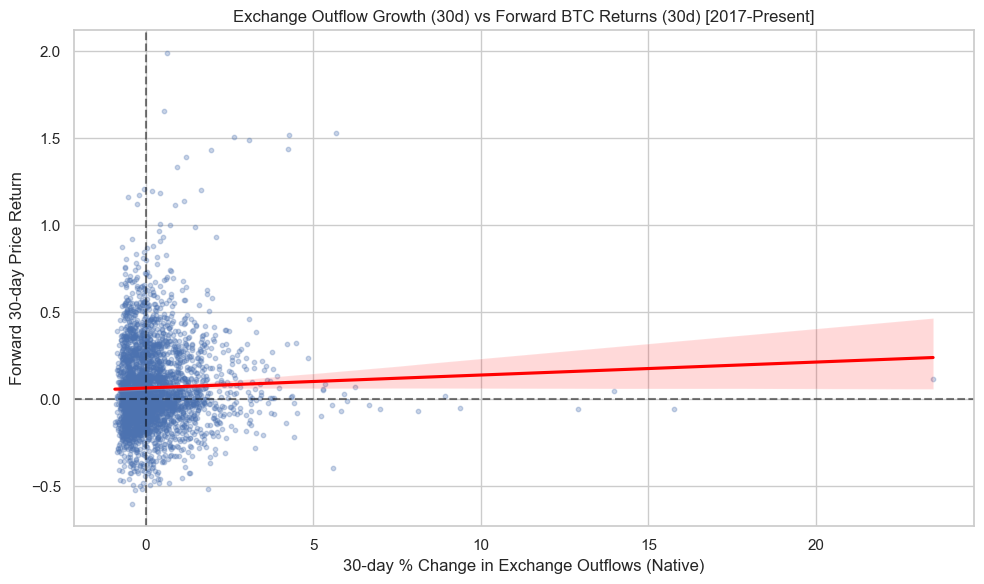

Correlation between 30d Outflow Growth and Forward 30d Returns (2017+): 0.0340


In [ ]:
outflow_df = (
    btc_df.filter(pl.col("time").dt.year() >= 2017)
    .select(["time", "PriceUSD_coinmetrics", "FlowOutExNtv"])
    .drop_nulls()
    .to_pandas()
)
outflow_df["time"] = pd.to_datetime(outflow_df["time"])

# 30 day Exchange Outflow Growth (Lagged)
outflow_df["outflow_growth_30d"] = outflow_df["FlowOutExNtv"].pct_change(30)

# 30 day Price Return (Forward)
outflow_df["fwd_ret_30d"] = outflow_df["PriceUSD_coinmetrics"].shift(-30) / outflow_df["PriceUSD_coinmetrics"] - 1

plot_outflow_df = outflow_df.dropna()

plt.figure(figsize=(10, 6))
sns.regplot(data=plot_outflow_df, x="outflow_growth_30d", y="fwd_ret_30d",
            scatter_kws={'alpha':0.3, "s":10}, line_kws={'color':'red'})

plt.title("Exchange Outflow Growth (30d) vs Forward BTC Returns (30d) [2017-Present]")
plt.xlabel("30-day % Change in Exchange Outflows (Native)")
plt.ylabel("Forward 30-day Price Return")
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

correlation_out = plot_outflow_df["outflow_growth_30d"].corr(plot_outflow_df["fwd_ret_30d"])
print(f"Correlation between 30d Outflow Growth and Forward 30d Returns: {correlation_out:.4f}")

## 4) Extended BTC EDA - Baseline Strategy Analysis

In [147]:
EVAL_START = pd.Timestamp("2018-01-01")
EVAL_END_TARGET = pd.Timestamp("2025-12-31")
WINDOW_OFFSET = pd.DateOffset(years=1)
N_RANDOM = 200
RANDOM_MULTI_DAYS = 12
SEED = 42

btc_daily_pd = (
    btc_df
    .select(["time", "PriceUSD_coinmetrics"])
    .drop_nulls()
    .to_pandas()
    .rename(columns={"time": "date", "PriceUSD_coinmetrics": "price"})
)
btc_daily_pd["date"] = pd.to_datetime(btc_daily_pd["date"].dt.normalize())
btc_daily_pd = (
    btc_daily_pd
    .sort_values("date")
    .drop_duplicates(subset=["date"], keep="last")
    .set_index("date")
)

EVAL_END = min(EVAL_END_TARGET, btc_daily_pd.index.max())
window_starts = pd.date_range(EVAL_START, EVAL_END - WINDOW_OFFSET, freq="D")

expected_dates = pd.date_range(EVAL_START, EVAL_END, freq="D")
missing_eval_dates = expected_dates.difference(btc_daily_pd.index)

print(f"Evaluation date range: {EVAL_START.date()} to {EVAL_END.date()}")
print(f"Rolling 1-year windows: {len(window_starts):,}")
print(f"Missing price dates in eval range: {len(missing_eval_dates):,}")

Evaluation date range: 2018-01-01 to 2025-12-31
Rolling 1-year windows: 2,557
Missing price dates in eval range: 0


In [148]:
def evaluate_window(price_values: np.ndarray, rng: np.random.Generator) -> dict:
    inv_price = 1e8 / price_values
    n_days = len(inv_price)

    dca_spd = inv_price.mean()
    lump_start_spd = inv_price[0]
    lump_end_spd = inv_price[-1]

    oracle_best_spd = inv_price.max()
    oracle_worst_spd = inv_price.min()
    oracle_denom = oracle_best_spd - oracle_worst_spd
    dca_oracle_percentile = np.nan if oracle_denom == 0 else 100 * (dca_spd - oracle_worst_spd) / oracle_denom

    # Random one-shot baseline, spend all budget on one random day
    random_lump_idx = rng.integers(0, n_days, size=N_RANDOM)
    random_lump_spd = inv_price[random_lump_idx]

    # Random multi-shot baseline, spend budget equally on 12 random days
    random_multi_idx = rng.integers(0, n_days, size=(N_RANDOM, RANDOM_MULTI_DAYS))
    random_multi_spd = inv_price[random_multi_idx].mean(axis=1)

    trend_1y = (price_values[-1] / price_values[0]) - 1
    daily_ret = pd.Series(price_values).pct_change().dropna().to_numpy()
    ann_vol_1y = np.nan if daily_ret.size < 2 else daily_ret.std(ddof=1) * np.sqrt(365)

    return {
        "n_days": n_days,
        "dca_spd": dca_spd,
        "lump_start_spd": lump_start_spd,
        "lump_end_spd": lump_end_spd,
        "oracle_best_spd": oracle_best_spd,
        "oracle_worst_spd": oracle_worst_spd,
        "dca_oracle_percentile": dca_oracle_percentile,
        "random_lump_mean_spd": random_lump_spd.mean(),
        "random_lump_median_spd": np.median(random_lump_spd),
        "random_lump_p05_spd": np.quantile(random_lump_spd, 0.05),
        "random_lump_p95_spd": np.quantile(random_lump_spd, 0.95),
        "random_multi_mean_spd": random_multi_spd.mean(),
        "random_multi_median_spd": np.median(random_multi_spd),
        "dca_vs_random_lump_percentile": 100 * (random_lump_spd < dca_spd).mean(),
        "dca_vs_random_multi_percentile": 100 * (random_multi_spd < dca_spd).mean(),
        "win_vs_lump_start": dca_spd > lump_start_spd,
        "win_vs_lump_end": dca_spd > lump_end_spd,
        "win_vs_random_lump_median": dca_spd > np.median(random_lump_spd),
        "win_vs_random_multi_median": dca_spd > np.median(random_multi_spd),
        "beats_random_lump_p05": dca_spd > np.quantile(random_lump_spd, 0.05),
        "trend_1y": trend_1y,
        "ann_vol_1y": ann_vol_1y,
    }

rng = np.random.default_rng(SEED)
rows = []

for start in window_starts:
    end = start + WINDOW_OFFSET
    window_prices = btc_daily_pd.loc[start:end, "price"].dropna()

    row = evaluate_window(window_prices.to_numpy(), rng)
    row["window_start"] = start
    row["window_end"] = end
    rows.append(row)

dca_eval_df = pd.DataFrame(rows).set_index("window_start").sort_index()
print(f"Evaluated windows: {len(dca_eval_df):,}")
dca_eval_df.head(3)

Evaluated windows: 2,557


,n_days,dca_spd,lump_start_spd,lump_end_spd,oracle_best_spd,oracle_worst_spd,dca_oracle_percentile,random_lump_mean_spd,random_lump_median_spd,random_lump_p05_spd,...,dca_vs_random_lump_percentile,dca_vs_random_multi_percentile,win_vs_lump_start,win_vs_lump_end,win_vs_random_lump_median,win_vs_random_multi_median,beats_random_lump_p05,trend_1y,ann_vol_1y,window_end
window_start,,,,,,,,,,,,,,,,,,,,,
2018-01-01,366,14767.937008,7426.852772,26259.691643,31396.44436,5846.725992,34.917062,14494.562958,14703.647476,8984.266342,...,50.0,49.5,True,False,True,False,True,-0.717177,0.829768,2019-01-01
2018-01-02,366,14817.734901,6777.674949,25652.881956,31396.44436,5846.725992,35.111968,15499.547628,14696.103222,8829.243549,...,51.0,48.5,True,False,True,False,True,-0.735793,0.824318,2019-01-02
2018-01-03,366,14871.414334,6662.098173,26424.347405,31396.44436,5846.725992,35.322066,14983.241494,14522.905652,8904.234301,...,55.0,57.0,True,False,True,True,True,-0.747880,0.824497,2019-01-03


In [149]:
def bootstrap_ci_mean(values, n_boot: int = 2000, alpha: float = 0.05, seed: int = 123):
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return (np.nan, np.nan, np.nan)

    local_rng = np.random.default_rng(seed)
    samples = local_rng.choice(arr, size=(n_boot, arr.size), replace=True)
    means = samples.mean(axis=1)
    lower = np.quantile(means, alpha / 2)
    upper = np.quantile(means, 1 - alpha / 2)
    return (arr.mean(), lower, upper)


win_rate_random_lump = dca_eval_df["win_vs_random_lump_median"].mean()
win_rate_random_multi = dca_eval_df["win_vs_random_multi_median"].mean()
win_rate_lump_start = dca_eval_df["win_vs_lump_start"].mean()
win_rate_lump_end = dca_eval_df["win_vs_lump_end"].mean()

oracle_median = dca_eval_df["dca_oracle_percentile"].median()
random_lump_pct_median = dca_eval_df["dca_vs_random_lump_percentile"].median()
random_multi_pct_median = dca_eval_df["dca_vs_random_multi_percentile"].median()

beats_lump_p05_rate = dca_eval_df["beats_random_lump_p05"].mean()

binom_random_lump = binomtest(
    int(dca_eval_df["win_vs_random_lump_median"].sum()),
    len(dca_eval_df),
    p=0.5,
    alternative="greater",
)
binom_random_multi = binomtest(
    int(dca_eval_df["win_vs_random_multi_median"].sum()),
    len(dca_eval_df),
    p=0.5,
    alternative="greater",
)

mean_oracle_pct, oracle_ci_lo, oracle_ci_hi = bootstrap_ci_mean(dca_eval_df["dca_oracle_percentile"].values)
mean_win_lump, win_lump_ci_lo, win_lump_ci_hi = bootstrap_ci_mean(dca_eval_df["win_vs_random_lump_median"].astype(float).values)

summary_table = pd.DataFrame(
    {
        "metric": [
            "Window count",
            "Median DCA oracle percentile",
            "Mean DCA oracle percentile",
            "Median DCA percentile vs random one-shot",
            "Median DCA percentile vs random 12-shot",
            "Win rate vs lump-sum at window start",
            "Win rate vs lump-sum at window end",
            "Win rate vs random one-shot median",
            "Win rate vs random 12-shot median",
            "Rate(DCA > random one-shot p05)",
            "Sign-test p-value (vs random one-shot)",
            "Sign-test p-value (vs random 12-shot)",
        ],
        "value": [
            f"{len(dca_eval_df):,}",
            f"{oracle_median:.2f}%",
            f"{mean_oracle_pct:.2f}% (95% CI: {oracle_ci_lo:.2f}, {oracle_ci_hi:.2f})",
            f"{random_lump_pct_median:.2f}%",
            f"{random_multi_pct_median:.2f}%",
            f"{100 * win_rate_lump_start:.2f}%",
            f"{100 * win_rate_lump_end:.2f}%",
            f"{100 * win_rate_random_lump:.2f}% (95% CI: {100 * win_lump_ci_lo:.2f}, {100 * win_lump_ci_hi:.2f})",
            f"{100 * win_rate_random_multi:.2f}%",
            f"{100 * beats_lump_p05_rate:.2f}%",
            f"{binom_random_lump.pvalue:.4g}",
            f"{binom_random_multi.pvalue:.4g}",
        ],
    }
)
summary_table

,metric,value
0,Window count,"2,557"
1,Median DCA oracle percentile,38.49%
2,Mean DCA oracle percentile,"38.70% (95% CI: 38.41, 39.00)"
3,Median DCA percentile vs random one-shot,57.00%
4,Median DCA percentile vs random 12-shot,51.00%
5,Win rate vs lump-sum at window start,35.16%
6,Win rate vs lump-sum at window end,76.14%
7,Win rate vs random one-shot median,"75.21% (95% CI: 73.56, 76.89)"
8,Win rate vs random 12-shot median,61.09%
9,Rate(DCA > random one-shot p05),100.00%


In [150]:
# Baseline robustness
baseline_criteria = pd.DataFrame(
    {
        "criterion": [
            "Win rate vs random one-shot median > 60%",
            "Sign-test p-value vs random one-shot < 0.01",
            "Rate(DCA > random one-shot p05) >= 90%",
        ],
        "result": [
            win_rate_random_lump > 0.60,
            binom_random_lump.pvalue < 0.01,
            beats_lump_p05_rate >= 0.90,
        ],
        "value": [
            f"{100 * win_rate_random_lump:.2f}%",
            f"{binom_random_lump.pvalue:.4g}",
            f"{100 * beats_lump_p05_rate:.2f}%",
        ],
    }
)

baseline_decision = (
    "KEEP DCA BASELINE (ROBUSTNESS)"
    if baseline_criteria["result"].all()
    else "REJECT DCA BASELINE (ROBUSTNESS)"
)

# Timing diagnostic (secondary, non-gating).
timing_diagnostic = pd.DataFrame(
    {
        "metric": ["Median DCA oracle percentile"],
        "target": [">= 50%"],
        "value": [f"{oracle_median:.2f}%"],
        "result": [oracle_median >= 50],
    }
)

timing_interpretation = (
    "TIMING DIAGNOSTIC PASS"
    if timing_diagnostic.loc[0, "result"]
    else "TIMING DIAGNOSTIC FAIL (timing layer likely useful)"
)

print(f"Primary decision: {baseline_decision}")
print(f"Secondary timing note: {timing_interpretation}")
baseline_criteria, timing_diagnostic


Primary decision: KEEP DCA BASELINE (ROBUSTNESS)
Secondary timing note: TIMING DIAGNOSTIC FAIL (timing layer likely useful)


(                                     criterion  result       value
 0     Win rate vs random one-shot median > 60%    True      75.21%
 1  Sign-test p-value vs random one-shot < 0.01    True  4.488e-150
 2       Rate(DCA > random one-shot p05) >= 90%    True     100.00%,
                          metric  target   value  result
 0  Median DCA oracle percentile  >= 50%  38.49%   False)

In [151]:
# Basic Regime Analysis
dca_eval_regime = dca_eval_df.copy()

trend_bins = pd.cut(
    dca_eval_regime["trend_1y"],
    bins=[-np.inf, -0.20, 0.20, np.inf],
    labels=["bear", "sideways", "bull"],
)

vol_median = dca_eval_regime["ann_vol_1y"].median()
vol_bucket = np.where(dca_eval_regime["ann_vol_1y"] > vol_median, "high_vol", "low_vol")

dca_eval_regime["trend_regime"] = trend_bins.astype(str)
dca_eval_regime["vol_regime"] = vol_bucket

regime_summary = (
    dca_eval_regime
    .groupby(["trend_regime", "vol_regime"], dropna=False)
    .agg(
        windows=("dca_spd", "count"),
        median_oracle_pct=("dca_oracle_percentile", "median"),
        win_vs_lump_start=("win_vs_lump_start", "mean"),
        win_vs_lump_end=("win_vs_lump_end", "mean"),
        win_vs_random_lump=("win_vs_random_lump_median", "mean"),
        beats_random_lump_p05=("beats_random_lump_p05", "mean"),
    )
    .reset_index()
)

for col in ["win_vs_lump_start", "win_vs_lump_end", "win_vs_random_lump", "beats_random_lump_p05"]:
    regime_summary[col] = 100 * regime_summary[col]

regime_summary

,trend_regime,vol_regime,windows,median_oracle_pct,win_vs_lump_start,win_vs_lump_end,win_vs_random_lump,beats_random_lump_p05
0,bear,high_vol,254,36.125800,78.740157,5.118110,86.614173,100.0
1,bear,low_vol,293,45.046889,100.000000,31.399317,54.266212,100.0
2,bull,high_vol,813,37.084609,20.787208,93.603936,79.581796,100.0
3,bull,low_vol,860,39.476043,3.139535,100.000000,70.697674,100.0
4,sideways,high_vol,211,31.906538,69.194313,68.246445,95.260664,100.0
5,sideways,low_vol,126,40.038459,50.793651,61.111111,69.841270,100.0


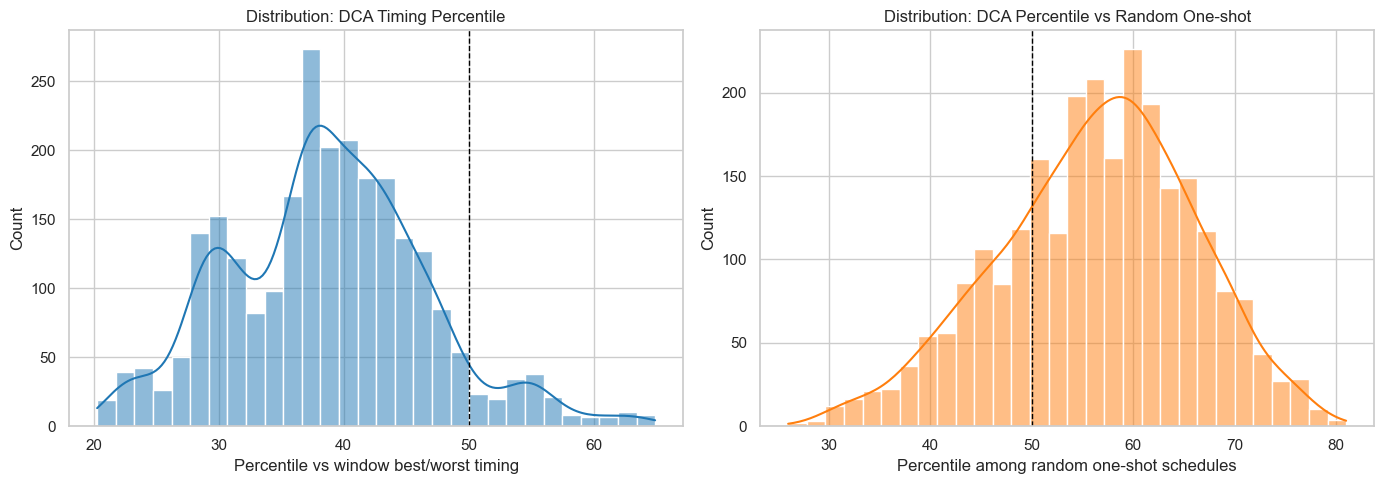

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(dca_eval_df["dca_oracle_percentile"], bins=30, kde=True, ax=axes[0], color="tab:blue")
axes[0].axvline(50, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Distribution: DCA Timing Percentile")
axes[0].set_xlabel("Percentile vs window best/worst timing")

sns.histplot(dca_eval_df["dca_vs_random_lump_percentile"], bins=30, kde=True, ax=axes[1], color="tab:orange")
axes[1].axvline(50, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Distribution: DCA Percentile vs Random One-shot")
axes[1].set_xlabel("Percentile among random one-shot schedules")

plt.tight_layout()
plt.show()

## 4 b) Extended Baseline Strategy - DCA vs MA200 vs RSI

In [153]:
MA_WINDOW = 200
RSI_WINDOW = 14
MIN_W = 1e-6

STRATEGY_LABELS = {
    "dca_uniform": "DCA (uniform)",
    "ma200_gate": "MA-200 gate",
    "rsi14_tilt": "RSI-14 tilt",
}

strategy_defs = pd.DataFrame(
    {
        "strategy": [
            "DCA (uniform)",
            "MA-200 gate",
            "RSI-14 tilt",
        ],
        "signal_rule": [
            "Equal weight every day.",
            "High weight when prior-day price is below prior-day MA-200; near-zero when above.",
            "Lagged RSI<30 => overweight, 30-70 => neutral, RSI>70 => near-zero.",
        ],
    }
)
strategy_defs

,strategy,signal_rule
0,DCA (uniform),Equal weight every day.
1,MA-200 gate,High weight when prior-day price is below prio...
2,RSI-14 tilt,"Lagged RSI<30 => overweight, 30-70 => neutral,..."


In [154]:
strategy_df = btc_daily_pd.copy()
strategy_df["ma200"] = strategy_df["price"].rolling(MA_WINDOW, min_periods=MA_WINDOW // 2).mean()
strategy_df["price_lag"] = strategy_df["price"].shift(1)
strategy_df["ma200_lag"] = strategy_df["ma200"].shift(1)

delta = strategy_df["price"].diff()
gains = delta.clip(lower=0)
losses = (-delta).clip(lower=0)
avg_gain = gains.ewm(alpha=1 / RSI_WINDOW, adjust=False, min_periods=RSI_WINDOW).mean()
avg_loss = losses.ewm(alpha=1 / RSI_WINDOW, adjust=False, min_periods=RSI_WINDOW).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
strategy_df["rsi14"] = 100 - (100 / (1 + rs))
strategy_df["rsi14_lag"] = strategy_df["rsi14"].shift(1)

strategy_df[["price", "ma200_lag", "rsi14_lag"]].tail(5)

,price,ma200_lag,rsi14_lag
date,,,
2026-01-09,90539.603229,106500.115349,53.980705
2026-01-10,90406.142411,106425.328628,51.859956
2026-01-11,90717.206315,106347.539014,51.339788
2026-01-12,91141.149849,106264.599720,52.534788
2026-01-13,95304.498294,106185.241355,54.186119


In [155]:
def _compute_stable_signal(raw: np.ndarray) -> np.ndarray:
    n = len(raw)
    if n == 0:
        return np.array([])
    if n == 1:
        return np.array([1.0])

    cumsum = np.cumsum(raw)
    running_mean = cumsum / np.arange(1, n + 1)
    with np.errstate(divide="ignore", invalid="ignore"):
        signal = raw / running_mean
    return np.where(np.isfinite(signal), signal, 1.0)


def normalize_weights(raw: np.ndarray, min_w: float = MIN_W) -> np.ndarray:
    """Sequential no-lookahead allocation."""
    raw = np.asarray(raw, dtype=float)
    raw[~np.isfinite(raw)] = 0.0
    raw = np.clip(raw, 0.0, None)

    if raw.sum() <= 0:
        raw = np.ones_like(raw)

    n = len(raw)
    if n == 0:
        return np.array([])

    base = 1.0 / n
    w = np.zeros(n, dtype=float)

    for i in range(n):
        signal_i = _compute_stable_signal(raw[: i + 1])[-1]
        w[i] = signal_i * base

    total = w.sum()
    if total <= 0:
        w = np.full(n, 1.0 / n)
    else:
        if total > 1.0 + 1e-10:
            w *= 1.0 / total

        if n > 1:
            w[-1] = max(1.0 - w[:-1].sum(), 0.0)
        else:
            w[0] = 1.0

    w = np.maximum(w, min_w)
    w = w / w.sum()
    return w


def raw_signal(window_df: pd.DataFrame, strategy_key: str) -> np.ndarray:
    n = len(window_df)

    if strategy_key == "dca_uniform":
        return np.ones(n, dtype=float)

    if strategy_key == "ma200_gate":
        buy_mask = window_df["ma200_lag"].notna() & (window_df["price_lag"] < window_df["ma200_lag"])
        return buy_mask.astype(float).to_numpy()

    if strategy_key == "rsi14_tilt":
        rsi = window_df["rsi14_lag"].to_numpy(dtype=float)
        raw = np.where(rsi < 30, 1.5, np.where(rsi > 70, 0.0, 1.0))
        raw[np.isnan(rsi)] = 1.0
        return raw

    raise ValueError(f"Unknown strategy: {strategy_key}")


def evaluate_strategies_for_window(window_df: pd.DataFrame, rng: np.random.Generator) -> list[dict]:
    inv_price = 1e8 / window_df["price"].to_numpy(dtype=float)
    n_days = len(inv_price)

    random_lump_idx = rng.integers(0, n_days, size=N_RANDOM)
    random_lump_spd = inv_price[random_lump_idx]

    random_multi_idx = rng.integers(0, n_days, size=(N_RANDOM, RANDOM_MULTI_DAYS))
    random_multi_spd = inv_price[random_multi_idx].mean(axis=1)

    oracle_best_spd = inv_price.max()
    oracle_worst_spd = inv_price.min()
    oracle_denom = oracle_best_spd - oracle_worst_spd

    out = []
    for key, label in STRATEGY_LABELS.items():
        w = normalize_weights(raw_signal(window_df, key))
        spd = float((w * inv_price).sum())

        oracle_pct = np.nan if oracle_denom == 0 else 100 * (spd - oracle_worst_spd) / oracle_denom

        out.append(
            {
                "strategy_key": key,
                "strategy": label,
                "spd": spd,
                "oracle_percentile": oracle_pct,
                "pct_vs_random_lump": 100 * (random_lump_spd < spd).mean(),
                "pct_vs_random_multi": 100 * (random_multi_spd < spd).mean(),
                "win_vs_random_lump_median": spd > np.median(random_lump_spd),
                "win_vs_random_multi_median": spd > np.median(random_multi_spd),
                "beats_random_lump_p05": spd > np.quantile(random_lump_spd, 0.05),
            }
        )

    return out

In [156]:
# Evaluate all strategies across rolling 1-year windows.
multi_rng = np.random.default_rng(SEED)
multi_rows = []

for start in window_starts:
    end = start + WINDOW_OFFSET
    window_df = strategy_df.loc[start:end, ["price", "price_lag", "ma200_lag", "rsi14_lag"]].dropna(subset=["price"])

    window_result = evaluate_strategies_for_window(window_df, multi_rng)
    for row in window_result:
        row["window_start"] = start
        row["window_end"] = end
        multi_rows.append(row)

multi_eval_df = pd.DataFrame(multi_rows).sort_values(["strategy", "window_start"])
print(f"Rows in multi-strategy evaluation: {len(multi_eval_df):,}")
multi_eval_df.head(6)

Rows in multi-strategy evaluation: 7,671


,strategy_key,strategy,spd,oracle_percentile,pct_vs_random_lump,pct_vs_random_multi,win_vs_random_lump_median,win_vs_random_multi_median,beats_random_lump_p05,window_start,window_end
0,dca_uniform,DCA (uniform),14767.937008,34.917062,50.0,49.5,True,False,True,2018-01-01,2019-01-01
3,dca_uniform,DCA (uniform),14817.734901,35.111968,51.0,48.5,True,False,True,2018-01-02,2019-01-02
6,dca_uniform,DCA (uniform),14871.414334,35.322066,55.0,57.0,True,True,True,2018-01-03,2019-01-03
9,dca_uniform,DCA (uniform),14924.595888,35.530215,65.0,57.0,True,True,True,2018-01-04,2019-01-04
12,dca_uniform,DCA (uniform),14978.393221,35.740775,56.5,56.0,True,True,True,2018-01-05,2019-01-05
15,dca_uniform,DCA (uniform),15029.848123,35.942166,54.0,54.5,True,True,True,2018-01-06,2019-01-06


In [157]:
# Apply the same primary criteria for each strategy.
strategy_summary_rows = []

for strategy_name, g in multi_eval_df.groupby("strategy"):
    n = len(g)
    win_rate_random_lump = g["win_vs_random_lump_median"].mean()
    p_value = binomtest(int(g["win_vs_random_lump_median"].sum()), n, p=0.5, alternative="greater").pvalue
    downside_rate = g["beats_random_lump_p05"].mean()
    timing_median = g["oracle_percentile"].median()

    primary_pass = (
        (win_rate_random_lump > 0.60)
        and (p_value < 0.01)
        and (downside_rate >= 0.90)
    )

    strategy_summary_rows.append(
        {
            "strategy": strategy_name,
            "windows": n,
            "median_oracle_percentile": timing_median,
            "median_pct_vs_random_lump": g["pct_vs_random_lump"].median(),
            "win_rate_vs_random_lump_median": 100 * win_rate_random_lump,
            "win_rate_vs_random_multi_median": 100 * g["win_vs_random_multi_median"].mean(),
            "downside_rate_vs_random_lump_p05": 100 * downside_rate,
            "sign_test_pvalue_vs_random_lump": p_value,
            "primary_baseline_pass": primary_pass,
            "timing_diagnostic_pass": timing_median >= 50,
        }
    )

strategy_summary = pd.DataFrame(strategy_summary_rows).sort_values(
    ["primary_baseline_pass", "median_oracle_percentile"],
    ascending=[False, False],
)

strategy_summary


,strategy,windows,median_oracle_percentile,median_pct_vs_random_lump,win_rate_vs_random_lump_median,win_rate_vs_random_multi_median,downside_rate_vs_random_lump_p05,sign_test_pvalue_vs_random_lump,primary_baseline_pass,timing_diagnostic_pass
1,MA-200 gate,2557,38.895523,63.5,77.864685,54.986312,100.0,5.159084e-185,True,False
0,DCA (uniform),2557,38.493668,57.0,75.205319,61.087212,100.0,4.488439e-150,True,False
2,RSI-14 tilt,2557,38.196954,56.5,72.976144,42.940946,100.0,4.822664e-124,True,False


In [158]:
# Direct comparison vs DCA
pivot_spd = multi_eval_df.pivot(index="window_start", columns="strategy", values="spd")
pivot_oracle = multi_eval_df.pivot(index="window_start", columns="strategy", values="oracle_percentile")

dca_label = STRATEGY_LABELS["dca_uniform"]

comparison_rows = []
for strategy_name in strategy_summary["strategy"]:
    if strategy_name == dca_label:
        continue

    common_idx = pivot_spd[[dca_label, strategy_name]].dropna().index
    if len(common_idx) == 0:
        continue

    spd_delta = pivot_spd.loc[common_idx, strategy_name] - pivot_spd.loc[common_idx, dca_label]
    oracle_delta = pivot_oracle.loc[common_idx, strategy_name] - pivot_oracle.loc[common_idx, dca_label]

    win_vs_dca = (spd_delta > 0).mean()
    p_value_vs_dca = binomtest(int((spd_delta > 0).sum()), len(spd_delta), p=0.5, alternative="greater").pvalue

    comparison_rows.append(
        {
            "strategy": strategy_name,
            "windows": len(common_idx),
            "median_spd_delta_vs_dca": spd_delta.median(),
            "median_oracle_delta_vs_dca": oracle_delta.median(),
            "win_rate_vs_dca": 100 * win_vs_dca,
            "sign_test_pvalue_vs_dca": p_value_vs_dca,
        }
    )

vs_dca_table = pd.DataFrame(comparison_rows).sort_values("median_spd_delta_vs_dca", ascending=False)
vs_dca_table

,strategy,windows,median_spd_delta_vs_dca,median_oracle_delta_vs_dca,win_rate_vs_dca,sign_test_pvalue_vs_dca
0,MA-200 gate,2557,20.263415,0.441468,52.170512,0.014792
1,RSI-14 tilt,2557,-10.303685,-0.412259,39.538522,1.000000


In [159]:
# Regime-aware baseline comparison using previously defined dca_eval_regime labels.
regime_labels = (
    dca_eval_regime
    .reset_index()[["window_start", "trend_regime", "vol_regime"]]
)

multi_eval_regime_df = multi_eval_df.merge(regime_labels, on="window_start", how="left")

strategy_regime_summary = (
    multi_eval_regime_df
    .groupby(["strategy", "trend_regime", "vol_regime"], dropna=False)
    .agg(
        windows=("spd", "count"),
        median_spd=("spd", "median"),
        median_oracle_percentile=("oracle_percentile", "median"),
        win_rate_vs_random_lump_median=("win_vs_random_lump_median", "mean"),
        downside_rate_vs_random_lump_p05=("beats_random_lump_p05", "mean"),
    )
    .reset_index()
)

strategy_regime_summary["win_rate_vs_random_lump_median"] *= 100
strategy_regime_summary["downside_rate_vs_random_lump_p05"] *= 100

strategy_regime_summary.sort_values(["trend_regime", "vol_regime", "median_spd"], ascending=[True, True, False])

,strategy,trend_regime,vol_regime,windows,median_spd,median_oracle_percentile,win_rate_vs_random_lump_median,downside_rate_vs_random_lump_p05
6,MA-200 gate,bear,high_vol,254,2815.474636,35.760336,93.700787,100.0
12,RSI-14 tilt,bear,high_vol,254,2643.695159,36.970220,88.188976,100.0
0,DCA (uniform),bear,high_vol,254,2619.852978,36.125800,86.614173,100.0
1,DCA (uniform),bear,low_vol,293,4272.249161,45.046889,54.266212,100.0
7,MA-200 gate,bear,low_vol,293,4267.073302,42.487791,43.686007,100.0
13,RSI-14 tilt,bear,low_vol,293,4256.505922,45.732103,52.901024,100.0
2,DCA (uniform),bull,high_vol,813,10902.157434,37.084609,79.581796,100.0
14,RSI-14 tilt,bull,high_vol,813,10749.954116,34.871519,75.399754,100.0
8,MA-200 gate,bull,high_vol,813,8999.383944,29.791675,66.174662,100.0
3,DCA (uniform),bull,low_vol,860,2216.660853,39.476043,70.697674,100.0


In [160]:
# Does the best baseline vary by regime?
best_strategy_by_regime = (
    strategy_regime_summary
    .sort_values("median_spd", ascending=False)
    .groupby(["trend_regime", "vol_regime"], as_index=False)
    .head(1)
    .sort_values(["trend_regime", "vol_regime"])
)

best_counts = (
    best_strategy_by_regime
    .groupby("strategy")
    .size()
    .rename("regimes_where_best")
    .reset_index()
    .sort_values("regimes_where_best", ascending=False)
)

strategy_dispersion = (
    strategy_regime_summary
    .groupby("strategy")
    .agg(
        median_spd_min=("median_spd", "min"),
        median_spd_max=("median_spd", "max"),
        median_oracle_min=("median_oracle_percentile", "min"),
        median_oracle_max=("median_oracle_percentile", "max"),
        win_rate_min=("win_rate_vs_random_lump_median", "min"),
        win_rate_max=("win_rate_vs_random_lump_median", "max"),
    )
    .reset_index()
)
strategy_dispersion["median_spd_range"] = strategy_dispersion["median_spd_max"] - strategy_dispersion["median_spd_min"]
strategy_dispersion["median_oracle_range"] = strategy_dispersion["median_oracle_max"] - strategy_dispersion["median_oracle_min"]
strategy_dispersion["win_rate_range"] = strategy_dispersion["win_rate_max"] - strategy_dispersion["win_rate_min"]

print("Best strategy by regime:")
best_strategy_view = best_strategy_by_regime[["trend_regime", "vol_regime", "strategy", "windows", "median_spd", "median_oracle_percentile", "win_rate_vs_random_lump_median"]]
print(best_strategy_view.to_string(index=False))

print("\nBest-count summary:")
print(best_counts.to_string(index=False))

print("\nCross-regime dispersion by strategy:")
strategy_dispersion_view = strategy_dispersion[["strategy", "median_spd_range", "median_oracle_range", "win_rate_range"]].sort_values("win_rate_range", ascending=False)
print(strategy_dispersion_view.to_string(index=False))

Best strategy by regime:
trend_regime vol_regime      strategy  windows   median_spd  median_oracle_percentile  win_rate_vs_random_lump_median
        bear   high_vol   MA-200 gate      254  2815.474636                 35.760336                       93.700787
        bear    low_vol DCA (uniform)      293  4272.249161                 45.046889                       54.266212
        bull   high_vol DCA (uniform)      813 10902.157434                 37.084609                       79.581796
        bull    low_vol DCA (uniform)      860  2216.660853                 39.476043                       70.697674
    sideways   high_vol   MA-200 gate      211 12434.565448                 37.772943                       98.578199
    sideways    low_vol   MA-200 gate      126  1680.138589                 65.047026                       73.015873

Best-count summary:
     strategy  regimes_where_best
DCA (uniform)                   3
  MA-200 gate                   3

Cross-regime dispersion b

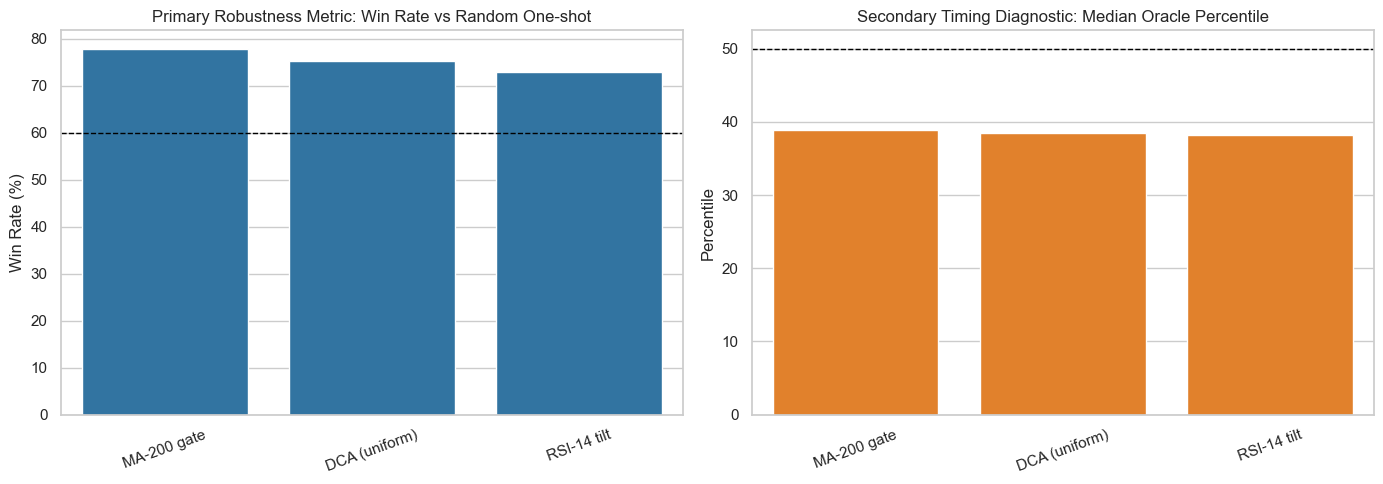

In [161]:
# Visual summary: robustness pass/fail and timing median by strategy.
plot_df = strategy_summary.copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    data=plot_df,
    x="strategy",
    y="win_rate_vs_random_lump_median",
    ax=axes[0],
    color="tab:blue",
)
axes[0].axhline(60, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Primary Robustness Metric: Win Rate vs Random One-shot")
axes[0].set_ylabel("Win Rate (%)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=20)

sns.barplot(
    data=plot_df,
    x="strategy",
    y="median_oracle_percentile",
    ax=axes[1],
    color="tab:orange",
)
axes[1].axhline(50, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Secondary Timing Diagnostic: Median Oracle Percentile")
axes[1].set_ylabel("Percentile")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

## 5) Basic Polymarket EDA

In [162]:
poly_overview = pl.DataFrame(
    {
        "table": list(poly_data.keys()),
        "rows": [poly_data[k].height for k in poly_data],
        "cols": [poly_data[k].width for k in poly_data],
    }
)
poly_overview

table,rows,cols
str,i64,i64
"""odds_history""",2143181,4
"""summary""",78321,9
"""trades""",27013724,9
"""markets""",78321,10
"""tokens""",156636,3
"""event_stats""",44033,5


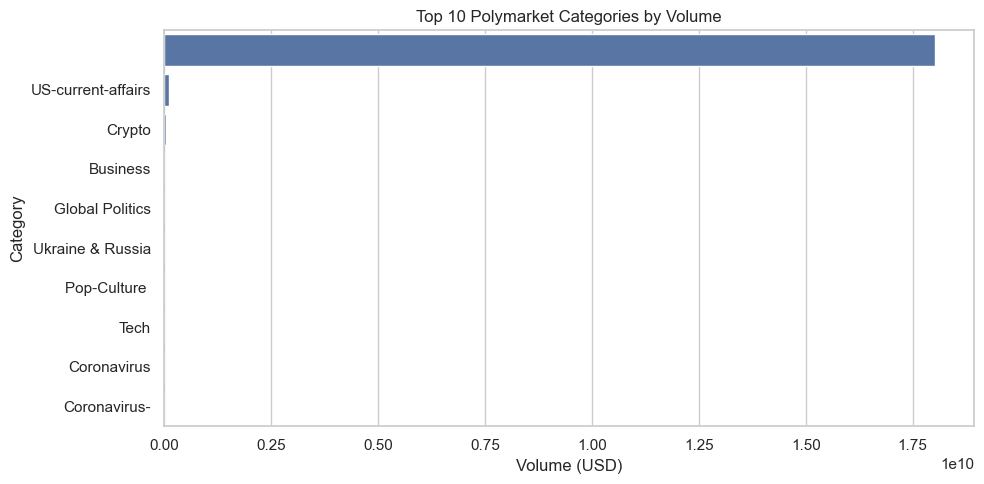

(shape: (1, 4)
 ┌───────────────┬────────────────┬────────────────┬──────────────────┐
 │ total_markets ┆ active_markets ┆ closed_markets ┆ total_volume_usd │
 │ ---           ┆ ---            ┆ ---            ┆ ---              │
 │ u32           ┆ u32            ┆ u32            ┆ f64              │
 ╞═══════════════╪════════════════╪════════════════╪══════════════════╡
 │ 78321         ┆ 78321          ┆ 73200          ┆ 1.8204e10        │
 └───────────────┴────────────────┴────────────────┴──────────────────┘,
 shape: (10, 3)
 ┌────────────────────┬──────────────┬─────────────────┐
 │ category           ┆ market_count ┆ category_volume │
 │ ---                ┆ ---          ┆ ---             │
 │ str                ┆ u32          ┆ f64             │
 ╞════════════════════╪══════════════╪═════════════════╡
 │                    ┆ 77516        ┆ 1.8032e10       │
 │ US-current-affairs ┆ 265          ┆ 1.1855e8        │
 │ Crypto             ┆ 340          ┆ 4.1457e7        │
 │ Busin

In [163]:
markets_df = poly_data["markets"]

market_status = markets_df.select(
    pl.len().alias("total_markets"),
    pl.col("active").sum().alias("active_markets"),
    pl.col("closed").sum().alias("closed_markets"),
    pl.col("volume").sum().alias("total_volume_usd")
)

top_categories = (
    markets_df
    .group_by("category")
    .agg(
        pl.len().alias("market_count"),
        pl.col("volume").sum().alias("category_volume"),
    )
    .sort("category_volume", descending=True)
    .head(10)
)

top_cat_pd = top_categories.to_pandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=top_cat_pd, x="category_volume", y="category")
plt.title("Top 10 Polymarket Categories by Volume")
plt.xlabel("Volume (USD)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

market_status, top_categories

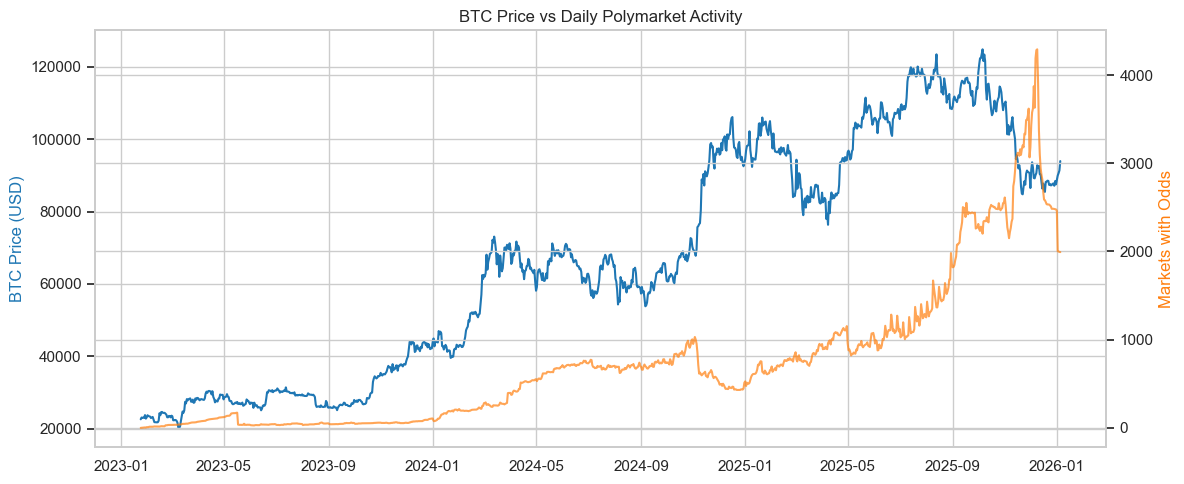

corr_btc_ret_vs_odds_obs,corr_btc_ret_vs_markets_with_odds,corr_btc_ret_vs_mean_odds_price
f64,f64,f64
-0.017957,-0.048327,0.017118


In [164]:
odds_df = poly_data["odds_history"]

odds_daily = (
    odds_df
    .drop_nulls(subset=["timestamp", "price"])
    .with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by("date")
    .agg(
        pl.len().alias("odds_obs"),
        pl.col("market_id").n_unique().alias("markets_with_odds"),
        pl.col("price").mean().alias("mean_odds_price"),
        pl.col("price").std().alias("odds_price_std"),
    )
    .sort("date")
)

btc_daily = (
    btc_df
    .select(
        pl.col("time").dt.date().alias("date"),
        pl.col("PriceUSD_coinmetrics").alias("btc_price"),
    )
    .drop_nulls()
    .sort("date")
    .with_columns(pl.col("btc_price").pct_change().alias("btc_ret_1d"))
)

merged_daily = btc_daily.join(odds_daily, on="date", how="inner").drop_nulls()

quick_corr = merged_daily.select(
    pl.corr("btc_ret_1d", "odds_obs").alias("corr_btc_ret_vs_odds_obs"),
    pl.corr("btc_ret_1d", "markets_with_odds").alias("corr_btc_ret_vs_markets_with_odds"),
    pl.corr("btc_ret_1d", "mean_odds_price").alias("corr_btc_ret_vs_mean_odds_price"),
)

plot_df = merged_daily.select(["date", "btc_price", "markets_with_odds"]).to_pandas()
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(plot_df["date"], plot_df["btc_price"], color="tab:blue", label="BTC Price")
ax1.set_ylabel("BTC Price (USD)", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(plot_df["date"], plot_df["markets_with_odds"], color="tab:orange", alpha=0.7, label="Markets with Odds")
ax2.set_ylabel("Markets with Odds", color="tab:orange")

plt.title("BTC Price vs Daily Polymarket Activity")
fig.tight_layout()
plt.show()

quick_corr

## 6) Extended Polymarket EDA

In [165]:
btc_targets = (
    poly_data['markets']
    .with_columns([
        pl.col("question").str.to_lowercase().alias("question_lc"),
    ])
    .filter(
        (pl.col("question_lc").str.contains("bitcoin|btc")) & 
        (pl.col("question_lc").str.contains("hit|reach|above|below|reach")) &
        (pl.col("volume") > 1000000)
    )
    .with_columns([
        pl.when(pl.col("question_lc").str.contains("above|reach|hit")).then(pl.lit(1))
        .when(pl.col("question_lc").str.contains("below|under")).then(pl.lit(-1))
        .otherwise(pl.lit(0)).alias("orientation")
    ])
    .filter(pl.col("orientation") != 0)
)

print(f"High-Liquidity BTC Markets: {btc_targets.height}")
with pl.Config(fmt_str_lengths=150):
    display(
        btc_targets.select(["market_id", "question", "volume"])
        .sort("volume", descending=True)
        .head(5)
    )

High-Liquidity BTC Markets: 174


market_id,question,volume
str,str,f64
"""512600""","""Will Bitcoin hit $100k in November?""",2.8587e7
"""255229""","""Will Bitcoin hit $100k in 2024?""",2.2807e7
"""618949""","""Will Bitcoin reach $200k in October?""",1.5617e7
"""659233""","""Will Bitcoin reach $200,000 in November?""",1.3589e7
"""516864""","""Will Bitcoin reach $150,000 by December 31, 2025?""",1.2479e7


In [166]:
target_ids = btc_targets["market_id"].to_list()

daily_probs = (
    poly_data["trades"]
    .filter(pl.col("market_id").is_in(target_ids))
    .with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by("date", "market_id")
    .agg(pl.col("price").mean().alias("avg_prob"))
    .join(btc_targets.select(["market_id", "orientation"]), on="market_id")
    .with_columns(
        pl.when(pl.col("orientation") == 1).then(pl.col("avg_prob"))
        .otherwise(1 - pl.col("avg_prob")).alias("bullish_prob")
    )
    .sort(["market_id", "date"])
    .with_columns(
        pl.col("bullish_prob").diff().over("market_id").alias("prob_delta")
    )
)

daily_sentiment = (
    daily_probs
    .group_by("date")
    .agg(pl.col("prob_delta").mean().alias("net_sentiment_delta"))
    .sort("date")
    .drop_nulls()
)

non_zero_deltas = daily_sentiment.filter(pl.col("net_sentiment_delta").abs() > 1e-9)
print(f"Days with active sentiment shift: {non_zero_deltas.height} / {daily_sentiment.height}")
print("Sample deltas:")
print(non_zero_deltas.head())

Days with active sentiment shift: 244 / 245
Sample deltas:
shape: (5, 2)
┌────────────┬─────────────────────┐
│ date       ┆ net_sentiment_delta │
│ ---        ┆ ---                 │
│ date       ┆ f64                 │
╞════════════╪═════════════════════╡
│ 2025-04-08 ┆ -0.023032           │
│ 2025-04-09 ┆ -0.041688           │
│ 2025-04-10 ┆ 0.019004            │
│ 2025-04-11 ┆ -0.006747           │
│ 2025-04-12 ┆ -0.018916           │
└────────────┴─────────────────────┘


In [167]:
horizons = [7, 14, 30, 60]
btc_cols = [pl.col("time").dt.date().alias("date"), pl.col("PriceUSD_coinmetrics")]

btc_returns = btc_df.select(btc_cols)
for h in horizons:
    btc_returns = btc_returns.with_columns(
        (pl.col("PriceUSD_coinmetrics").shift(-h) / pl.col("PriceUSD_coinmetrics") - 1).alias(f"fwd_{h}d_ret")
    )

daily_activity = (
    poly_data["trades"]
    .filter(pl.col("market_id").is_in(btc_targets["market_id"].to_list()))
    .with_columns(pl.col("timestamp").dt.date().alias("date"))
    .group_by("date")
    .agg(pl.len().alias("daily_trade_count"))
    .with_columns(
        ((pl.col("daily_trade_count") - pl.col("daily_trade_count").mean()) / pl.col("daily_trade_count").std()).alias("activity_zscore")
    )
)

analysis_df = (
    daily_sentiment
    .join(daily_activity, on="date", how="left")
    .join(btc_returns, on="date")
    .drop_nulls(subset=[f"fwd_{h}d_ret" for h in horizons])
)

print(f"Analysis sample size: {analysis_df.height} days")

Analysis sample size: 216 days


In [168]:
# T-Tests and Monte Carlo Simulation
sentiment_threshold = analysis_df["net_sentiment_delta"].quantile(0.95)
activity_threshold = 1.5 # z-score

def run_permutation_test(df, mask_col, ret_col, n_iter=1000):
    observed_diff = df.filter(pl.col(mask_col))[ret_col].mean() - df.filter(~pl.col(mask_col))[ret_col].mean()

    null_diffs = []
    vals = df[ret_col].to_numpy()
    n_shocks = df.filter(pl.col(mask_col)).height

    for _ in range(n_iter):
        perm = np.random.permutation(vals)
        null_diff = perm[:n_shocks].mean() - perm[n_shocks:].mean()
        null_diffs.append(null_diff)

    p_sim = (np.abs(null_diffs) >= np.abs(observed_diff)).mean()
    return observed_diff, p_sim

analysis_df = analysis_df.with_columns([
    (pl.col("net_sentiment_delta") >= sentiment_threshold).alias("is_sent_shock"),
    (pl.col("activity_zscore") >= activity_threshold).alias("is_act_shock")
])

results = []
for h in horizons:
    ret_col = f"fwd_{h}d_ret"

    #Sentiment Stats
    sent_diff, sent_p_sim = run_permutation_test(analysis_df, "is_sent_shock", ret_col)

    #Activitiy Stats
    act_diff, act_p_sim = run_permutation_test(analysis_df, "is_act_shock", ret_col)

    results.append({
        "horizon": f"{h}d",
        "sentiment_shock_diff": sent_diff,
        "sentiment_p_monte_carlo": sent_p_sim,
        "activity_shock_diff": act_diff,
        "activity_p_monte_carlo": act_p_sim
    })

report = pl.DataFrame(results)
print("Abnormal Returns & Sim-based P-values:")
print(report)


Abnormal Returns & Sim-based P-values:
shape: (4, 5)
┌─────────┬──────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ horizon ┆ sentiment_shock_diff ┆ sentiment_p_monte_c ┆ activity_shock_diff ┆ activity_p_monte_ca │
│ ---     ┆ ---                  ┆ arlo                ┆ ---                 ┆ rlo                 │
│ str     ┆ f64                  ┆ ---                 ┆ f64                 ┆ ---                 │
│         ┆                      ┆ f64                 ┆                     ┆ f64                 │
╞═════════╪══════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 7d      ┆ -0.014762            ┆ 0.332               ┆ -0.002668           ┆ 0.799               │
│ 14d     ┆ -0.02991             ┆ 0.149               ┆ 0.018122            ┆ 0.231               │
│ 30d     ┆ -0.046207            ┆ 0.175               ┆ 0.053746            ┆ 0.027               │
│ 60d     ┆ -0.079613            ┆ 0.0

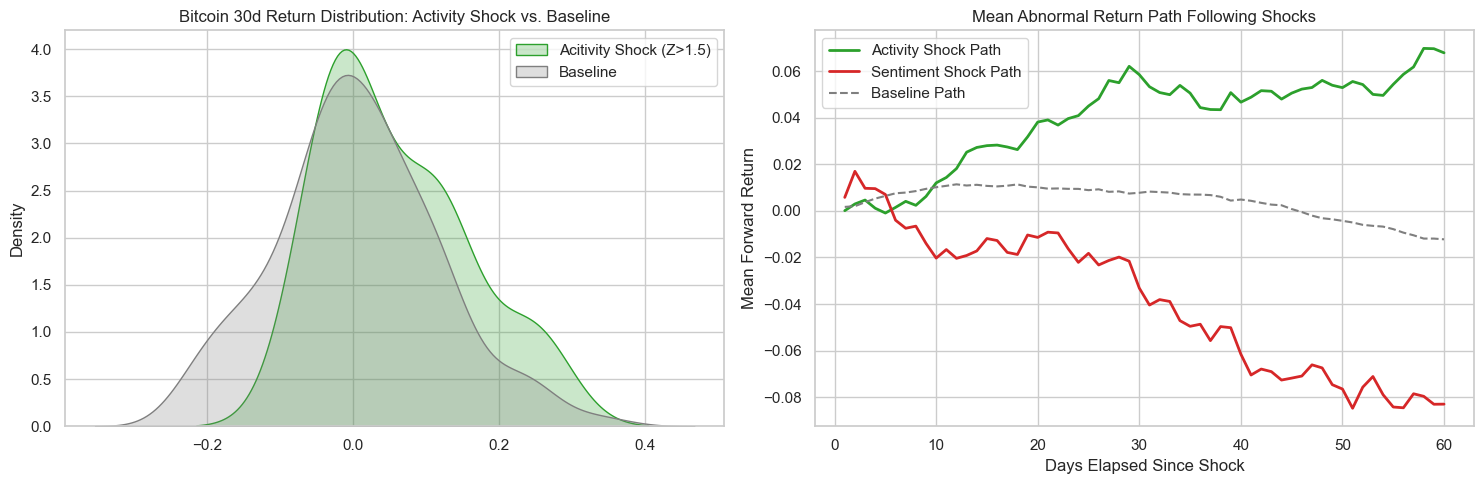

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Activity Shock Distribution (30d)
sns.kdeplot(analysis_df.filter(pl.col("is_act_shock"))["fwd_30d_ret"].to_numpy(),
            label="Acitivity Shock (Z>1.5)", fill=True, ax=axes[0], color="tab:green")
sns.kdeplot(analysis_df.filter(~pl.col("is_act_shock"))["fwd_30d_ret"].to_numpy(),
            label="Baseline", fill=True, ax=axes[0], color="tab:grey")
axes[0].set_title("Bitcoin 30d Return Distribution: Activity Shock vs. Baseline")
axes[0].legend()

# Cumulative Return Paths
path_horizons = list(range(1,61))
path_btc = btc_df.select([pl.col("time").dt.date().alias("date"), "PriceUSD_coinmetrics"])
for h in path_horizons:
    path_btc = path_btc.with_columns(
        (pl.col("PriceUSD_coinmetrics").shift(-h) / pl.col("PriceUSD_coinmetrics") - 1).alias(f"ret_{h}")
    )

path_df = analysis_df.select(["date", "is_act_shock", "is_sent_shock"]).join(path_btc, on="date")

act_path = [path_df.filter(pl.col("is_act_shock"))[f"ret_{h}"].mean() for h in path_horizons]
sent_path = [path_df.filter(pl.col("is_sent_shock"))[f"ret_{h}"].mean() for h in path_horizons]
base_path = [path_df.filter(~pl.col("is_act_shock") & ~pl.col("is_sent_shock"))[f"ret_{h}"].mean() for h in path_horizons]

axes[1].plot(path_horizons, act_path, label="Activity Shock Path", color="tab:green", linewidth=2)
axes[1].plot(path_horizons, sent_path, label="Sentiment Shock Path", color="tab:red", linewidth=2)
axes[1].plot(path_horizons, base_path, label="Baseline Path", color="tab:grey", linestyle='--')
axes[1].set_title("Mean Abnormal Return Path Following Shocks")
axes[1].set_xlabel("Days Elapsed Since Shock")
axes[1].set_ylabel("Mean Forward Return")
axes[1].legend()

plt.tight_layout()
plt.show()